## Loading all the needed things

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4003, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 4003 (delta 127), reused 181 (delta 55), pack-reused 3722
Receiving objects: 100% (4003/4003), 680.38 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (712/712), done.
Checking out files: 100% (2856/2856), done.
/content/STAT3007_Project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3958 sha256=c43042ee7602308f33e86e505c4f76173acfd09d262ebe7fea0daefd70e72c2a
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
from librosa import display

from IPython.display import Audio

# load our own python files
from pre_process import *
from data_loading import *
from CNN_Model import *

In [4]:
# produce emotion label

# 0 - calm; 1 - happy; 2 - sad; 3 - angry; 4 - surprised
target_map = {'02':0,'03':1,'04':2,'05':3,'08':4}
#target_map = {'01':0,'02':1,'03':2,'04':3,'05':4,'06':5,'07':6,'08':7}
min_time, max_time, min_sample, max_sample,min_file,max_file = find_min_max()

## Load Test Sample

We have 128x63 size mel-spectrograms. We want to apply each column of the jet colour map to the image to get a colour for that image.

In [37]:
#Spectrogram is n x 1 x 128 x 63 size image, jet is 64x3 64 colour map
def Make_All_RGB(spectrograms, jet):
  maxDB = np.max(spectrograms)
  minDB = np.min(spectrograms)
  interval_step = (maxDB - minDB)/64
  intervals = [(minDB + x * interval_step, minDB + (x + 1) * interval_step) for x in range(64)]

  RGB_images = []
  image_num = 0

  for image in spectrograms:
    print(image_num)
    spectrogram = image[0]
    red_image = []
    green_image = []
    blue_image = []

    for row in spectrogram:
      red_image_row = []
      green_image_row = []
      blue_image_row = []
      for pixel in row:
        counter = 0
        for interval in intervals:
          if interval[0] <= pixel <= interval[1]:
            index = counter 
            break
          counter += 1
        red_image_row.append(pixel * jet[index][0])
        green_image_row.append(pixel * jet[index][1])
        blue_image_row.append(pixel * jet[index][2])
      red_image.append(red_image_row)
      green_image.append(green_image_row)
      blue_image.append(blue_image_row)

    RGB_image = np.array([red_image, green_image, blue_image])
    RGB_images.append(RGB_image)
    image_num += 1
  return np.array(RGB_images)


In [41]:
#Spectrogram is 128 x 63 size image, jet is 64x3 64 colour map
def Make_RGB(spectrogram, jet):
  maxDB = np.max(spectrogram)
  minDB = np.min(spectrogram)
  interval_step = (maxDB - minDB)/64
  intervals = [(minDB + x * interval_step, minDB + (x + 1) * interval_step) for x in range(64)]

  red_image = []
  green_image = []
  blue_image = []

  for row in spectrogram:
    red_image_row = []
    green_image_row = []
    blue_image_row = []
    for pixel in row:
      counter = 0
      for interval in intervals:
        if interval[0] <= pixel <= interval[1]:
          index = counter 
          break
        counter += 1
      red_image_row.append(pixel * jet[index][0])
      green_image_row.append(pixel * jet[index][1])
      blue_image_row.append(pixel * jet[index][2])
    red_image.append(red_image_row)
    green_image.append(green_image_row)
    blue_image.append(blue_image_row)

  return np.array(red_image), np.array(green_image), np.array(blue_image)


In [7]:
images = Make_All_RGB([data[0][0], data2[0][0]], jet)

In [8]:
images.shape

(2, 3, 128, 63)

Text(0.5, 1.0, 'Blue')

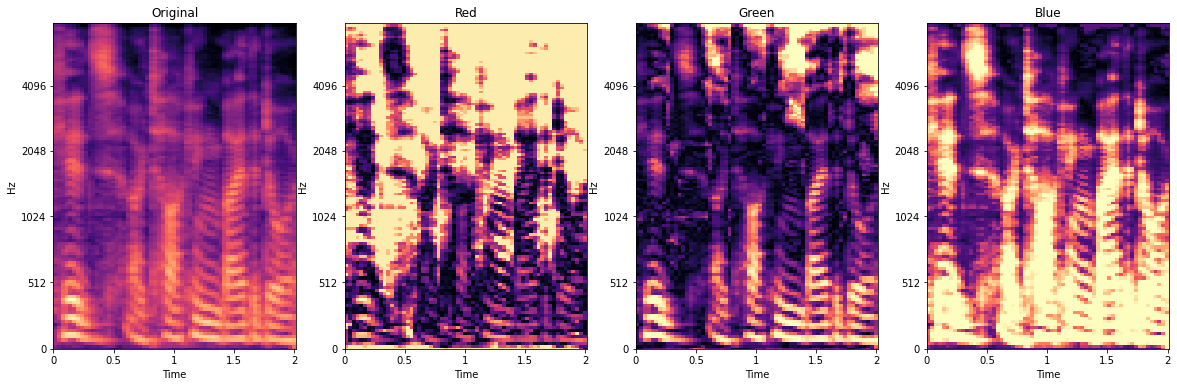

In [9]:
plt.figure(figsize = (20,6))
plt.subplot2grid((1,4),(0,0))
librosa.display.specshow(data2[0,0], y_axis='mel', fmax=8000, x_axis='time', sr =16000);
plt.title('Original')
plt.subplot2grid((1,4),(0,1))
librosa.display.specshow(images[1,0], y_axis='mel', fmax=8000, x_axis='time', sr =16000);
plt.title('Red')
plt.subplot2grid((1,4),(0,2))
librosa.display.specshow(images[1,1], y_axis='mel', fmax=8000, x_axis='time', sr =16000);
plt.title('Green')
plt.subplot2grid((1,4),(0,3))
librosa.display.specshow(images[1,2], y_axis='mel', fmax=8000, x_axis='time', sr =16000);
plt.title('Blue')

In [10]:
model = ConvNet_RGB(contain_linear = True)

In [15]:
thing = model(torch.tensor(images).type(torch.FloatTensor))

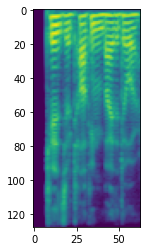

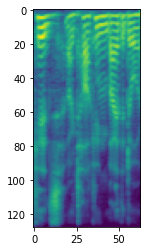

In [6]:
import scipy.io
mat = scipy.io.loadmat('/content/STAT3007_Project/jet.mat')
jet = mat['ans']
test = librosa.load('/content/STAT3007_Project/truncated_samples/Male/Actor_01/02-02-01-01-01.wav', sr = 16000)
test2 = librosa.load('/content/STAT3007_Project/truncated_samples/Male/Actor_01/02-02-01-02-01.wav', sr = 16000)
data = RGB_data_gen(test[0], test[1], duration=2)
data = data.reshape(1,1,128,63)
plt.imshow(data[0][0])
plt.figure()
data2 = RGB_data_gen(test2[0], test2[1], duration=2)
data2 = data2.reshape(1,1,128,63)
plt.imshow(data2[0][0])

## Load Clean Data

In [23]:
#Load the clean audio data
X,y = load_samples('/content/STAT3007_Project', padding = True, truncating = True, normal = True, duration = 2, Noisfy=False)
X = np.array(X)
# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])

In [24]:
X.shape

(480, 1, 128, 63)

In [38]:
RGB_images = Make_All_RGB(X, jet)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
RGB_images.shape

(480, 3, 128, 63)

In [40]:
X = torch.tensor(X)

y = torch.tensor(y)

In [ ]:
#Normalise Everything
from sklearn.preprocessing import minmax_scale
for i in range(X.shape[0]):
  X[i][0] = spec_normlisation(X[i][0])
  #X[i][0] = torch.tensor(minmax_scale(X[i][0].detach().numpy(), [-1,1]))

## Load All Noisy Data

In [ ]:
#Import all the noisy data
noisy_data = np.load('/content/drive/MyDrive/STAT3007 project/noisy_spectrograms_complete.npy')
noisy_targets = np.load('/content/drive/MyDrive/STAT3007 project/noisy_targets_complete.npy')

noisy_data = torch.tensor(noisy_data).reshape(noisy_data.shape[0],1,noisy_data.shape[1],noisy_data.shape[2])
noisy_targets = torch.tensor(noisy_targets)

# Training
Now we attempt to train on some datasets and see how it performs.
* Loss function: softmax
* learning rate = 0.01

In [42]:
def train_model(data_train, data_test, net, loss, nepoch ,lr = 0.01, batch_size = -1, use_cuda = False, print_output = True):

  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  optimizer = optim.SGD(net.parameters(), lr = lr)
  print(data_train)
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)

  if batch_size == -1:
    data_loader = DataLoader(data_train,
      batch_size = num_samples, shuffle = True)

  else:
    data_loader = DataLoader(data_train,
      batch_size = batch_size, shuffle = True)

  averageLosses = []
  averageAccuracies = []
  batchaverageAccuracies = []
  averageLossesTest = []
  X_test, y_test = data_test.get_data()
  X_test = X_test.type(torch.FloatTensor).to(torch.device('cuda'))
  y_test = y_test.type(torch.LongTensor).to(torch.device('cuda'))
  for epoch in range(nepoch):
    losses = []
    testLosses = []
    batch_accuracies = []
    accuracies = []
    for X_batch, y_batch in data_loader:
      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()

      # since all our values are negative, we convert them to positive


      pred = net(X_batch)
      Rn = loss(pred, y_batch)
      otherLoss = loss(net(X_test), y_test)
      losses.append(Rn.item())
      testLosses.append(otherLoss.item())
      batch_accuracy_score = accuracy(pred,y_batch)
      test_accuracy_score = accuracy(net(X_test),y_test)
      accuracies.append(test_accuracy_score)
      batch_accuracies.append(batch_accuracy_score)
      Rn.backward()
      optimizer.step()

    averageLosses.append(np.mean(np.array(losses)))
    averageLossesTest.append(np.mean(np.array(testLosses)))
    averageAccuracies.append(np.mean(np.array(accuracies)))
    batchaverageAccuracies.append(np.mean(np.array(batch_accuracies)))
    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')

  print('final loss:', Rn.item())

  return net, averageLosses, averageLossesTest, averageAccuracies, batchaverageAccuracies

In [43]:
#Clean
data_train, data_test = load_sets(RGB_images,y)[0]

#Noisy Samples
#thing, data_test = load_sets(X_noisy,y_noisy)[0]

#Noisy
#data_train, thing = load_sets(noisy_data,noisy_targets)[0]


loss = nn.CrossEntropyLoss()
nepoch = 20
batch_size = 10
for filter_num in [8]:
  torch.manual_seed(69)
  CNN = ConvNet_RGB(contain_linear = True, filter_num = filter_num)
  initial_state = CNN.state_dict()
  trained_net, averageLosses, averageLossesTest, accuracies, batch_accuracies = train_model(data_train,data_test, CNN, loss, nepoch = nepoch,lr = 0.01, batch_size = batch_size, use_cuda = True,print_output = False)
  X_test, y_test = data_test.get_data()
  X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
  trained_net = trained_net.to(torch.device('cpu'))
  y_pred = trained_net(X_test)
  accuracy_score = accuracy(y_pred,y_test)
  print('Filter Number is ' + str(filter_num) + ' accuracy:' + str(accuracy_score))

AttributeError: ignored

In [ ]:
y_pred.shape

torch.Size([144, 5])

In [ ]:
torch.argmax(y_pred)

tensor(545)

In [ ]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test, torch.argmax(y_pred, dim=1))
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)

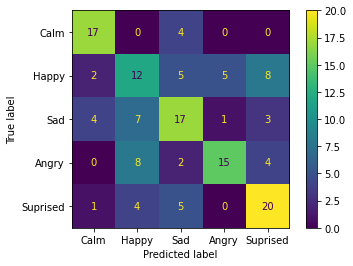

In [ ]:
thing.plot()

In [ ]:
jordan = librosa.load('/content/Jordan-angry-at-dog.wav', sr = 16000)
data = data_gen(jordan[0], jordan[1], duration=2)
data = data.reshape(1,1,128,63)

In [ ]:
trained_net(torch.tensor(data))

tensor([[ 1.2385, -3.9183,  1.2809, -7.5447,  7.4144]],
       grad_fn=<AddmmBackward>)

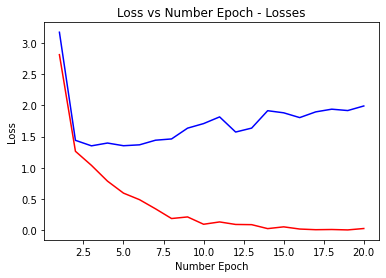

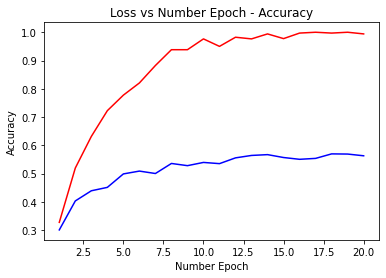

In [ ]:
plt.plot([x for x in range(1,nepoch+1)], averageLosses, 'r', [x for x in range(1,nepoch+1)], averageLossesTest, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Number Epoch - Losses")
plt.show()
plt.plot([x for x in range(1,nepoch+1)], batch_accuracies, 'r', [x for x in range(1,nepoch+1)], accuracies, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Accuracy")
plt.title("Loss vs Number Epoch - Accuracy")
plt.show()

# Testing

In [ ]:
X_test, y_test = data_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)
accuracy_score = accuracy(y_pred,y_test)
print('accuracy:' + str(accuracy_score))

accuracy:0.5902777910232544


In [ ]:
# inspecting features
X_test, y_test = data_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
first_layer,last_layer,y_pred = trained_net(X_test, inspect_feature = True)

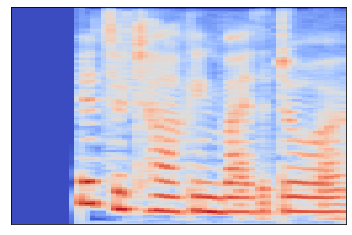

In [ ]:
librosa.display.specshow(X_test[1][0].detach().numpy())

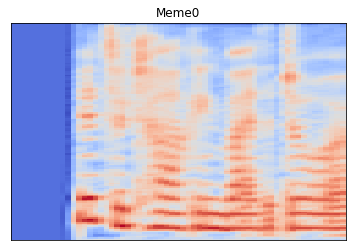

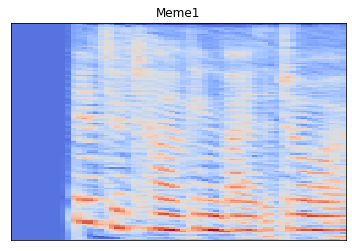

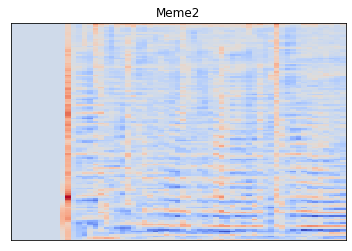

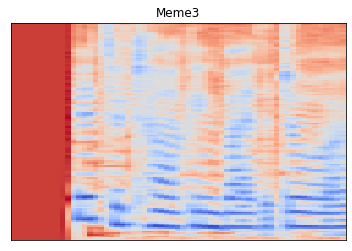

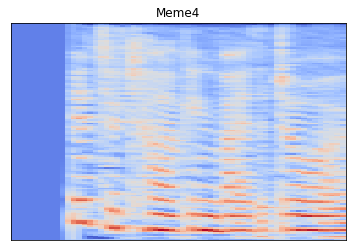

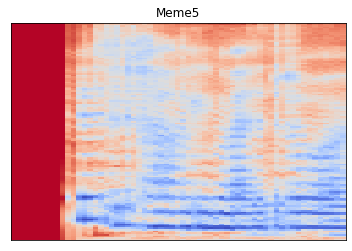

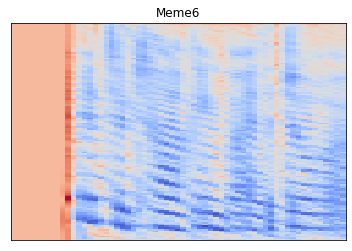

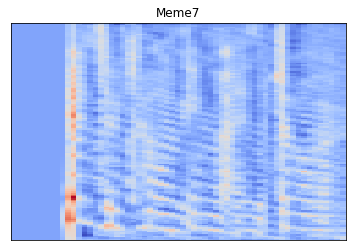

In [ ]:
# acitivation layer patterns
counter = 0
for i in first_layer[1].detach().numpy():
  plt.figure()
  plt.title("Meme" + str(counter))
  librosa.display.specshow(i)
  counter += 1